In [80]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [102]:
def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):
    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        MNIST('./ignore_dir/data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        MNIST('./ignore_dir/data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader


def overlay_y_on_x(x, y):
    x_ = x.clone()
    x_[:, :10] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    return x_


class Net(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1]).cuda()]

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = overlay_y_on_x(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)


class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()


In [237]:
torch.manual_seed(1234)
train_loader, test_loader = MNIST_loaders()

net = Net([784, 500, 500])
x, y = next(iter(train_loader))
x, y = x.cuda(), y.cuda()
x_pos = overlay_y_on_x(x, y)
rnd = torch.randperm(x.size(0))
x_neg = overlay_y_on_x(x, y[rnd])
net.train(x_pos, x_neg)

print('train error:', 1.0 - net.predict(x).eq(y).float().mean().item())

x_te, y_te = next(iter(test_loader))
x_te, y_te = x_te.cuda(), y_te.cuda()

print('test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())

torch.Size([50000, 784])
torch.Size([50000, 784])
training layer 0 ...


100%|██████████████████████████████████████| 1000/1000 [00:23<00:00, 42.44it/s]


training layer 1 ...


100%|██████████████████████████████████████| 1000/1000 [00:19<00:00, 52.12it/s]


torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
train error: 0.9103800058364868
torch.Size([10000, 784])
torch.Size([10000, 784])
torch.Size([10000, 784])
torch.Size([10000, 784])
torch.Size([10000, 784])
torch.Size([10000, 784])
torch.Size([10000, 784])
torch.Size([10000, 784])
torch.Size([10000, 784])
torch.Size([10000, 784])
test error: 0.910800002515316


torch.Size([50000, 784])


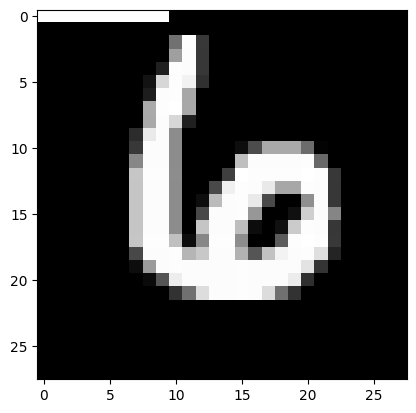

In [236]:
# train_loader, test_loader = MNIST_loaders()
# x, y = next(iter(train_loader))
# print(x.shape, y.shape)

def overlay_y_on_x(x, y):
    x_ = x.clone()

    x_[:, :10] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    
    return x_

xb = overlay_y_on_x(x, y)
plt.imshow(xb.reshape((50000, 1, 28, 28)).numpy()[0].transpose((1, 2, 0)), cmap="gray")
plt.show()

# index = 20
# xb, yb = x[index].unsqueeze(0), y[index].unsqueeze(0)
# xb = overlay_y_on_x(xb, yb)
# plt.imshow(xb.reshape((5, 1, 28, 28)).numpy()[0].transpose((1, 2, 0)), cmap="gray")
# plt.show()

In [126]:
x = xb.reshape((1, 28, 28))
x.shape

torch.Size([1, 28, 28])

In [128]:
x.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [142]:
import numpy as np
x = np.random.random((1, 28, 28))
print(x.shape)
x_1 = x[np.newaxis, :]
x_2 = np.expand_dims(x, 0)
x.shape, x_1.shape, x_2.shape

(1, 28, 28)


((1, 28, 28), (1, 1, 28, 28), (1, 1, 28, 28))

(1, 1, 1, 1, 28, 28)